# Scrape Addresses

The addresses data we're going to scrape are originated from [Doorplate Query System](https://www.ris.gov.tw/app/portal/3053) that provided by the Dept. of Household Registration, M.O.I.

In [1]:
import os

import pandas as pd
from dotenv import load_dotenv
from IPython import display
from twocaptcha import TwoCaptcha

from src.common.driver_helpers import start_driver
from src.common.request_helpers import lines_to_dict
from src.s1_scrape_addresses.helpers import (
    get_address_data,
    save_and_decode_captcha_image,
)

## Setup environment

`SESSION` will be added to the output file as postfix.

`QUERY_END_DATE` is to set the end-date of query, it should in the format of `YYY-MM-DD`, the year should be `year - 1911`, e.g. `2022-12-01` turns into `111-12-01`.

In [8]:
load_dotenv()

SESSION: str = os.getenv("SESSION")
print(f'{SESSION=}')

QUERY_END_DATE: str = os.getenv("QUERY_END_DATE")
print(f'{QUERY_END_DATE=}')

img_dir = "data/raw/captcha"
output_dir = "results"

# * replace to your local driver and chrome path if you prefer running in local machine
driver_path = "Z:/apps/chromium_87.0.4276.0/chromedriver_86.0.4240.22.exe"
chrome_path = "Z:/apps/chromium_87.0.4276.0/chrome.exe"

SESSION='221201'
QUERY_END_DATE='111-12-01'


## Load services

Input `driver_path` and `chrome_path` to `start_driver()` if you prefer running in local machine.

In [20]:
# driver = start_driver(driver_path=driver_path, chrome_path=chrome_path)  # run in local machine
driver = start_driver()  # run in docker

solver = TwoCaptcha(os.getenv("TWO_CAPTCHA_API_KEY"))

## Read town data

In [5]:
town_df = pd.read_csv(f"data/processed/town/town.csv")
town_df = town_df[["COUNTYCODE", "TOWNCODE"]]
town_df

,COUNTYCODE,TOWNCODE
0,64000,64000160
1,10014,10014150
2,64000,64000120
3,10010,10010090
4,68000,68000130
...,...,...
363,66000,66000280
364,66000,66000010
365,10018,10018020
366,10004,10004020


## Go to target website

In [21]:
driver.get("https://www.ris.gov.tw/info-doorplate/app/doorplate/query")
driver.save_screenshot("data/temp/screenshot.png")

True

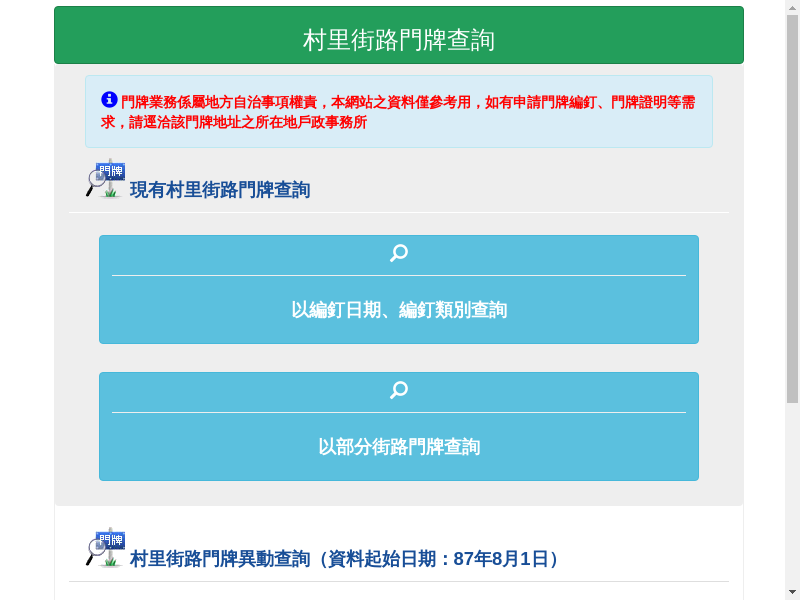

In [22]:
display.Image("data/temp/screenshot.png")

## Prepare default query data

We're going to query the addresses of each town. The query data primarily needs these fields:

- `cityCode`: the county code.
- `areaCode`: the town code.
- `rows`: set to `99999999` to get all addresses of that town at once.
- `captchaKey`: the key of captcha image.
- `captchaInput`: decoded result of captcha image.
- `sDate` and `eDate`: start-date and end-date. The response data of every address has `date` field that indicates created, updated or removed date of that address. Usually, we're querying all addresses so set `eDate` to present date.

In [24]:
query_url = "https://www.ris.gov.tw/info-doorplate/app/doorplate/inquiry/date"
query_data = lines_to_dict("data/external/query_data.txt")
query_data["eDate"] = QUERY_END_DATE

query_data

{'searchType': 'date',
 'cityCode': '65000000',
 'tkt': '-1',
 'areaCode': '65000290',
 'village': '',
 'neighbor': '',
 'sDate': '001-01-01',
 'eDate': '111-12-01',
 'includeNoDate': 'true',
 '_includeNoDate': 'on',
 'registerKind': '0',
 'floor': '',
 'lane': '',
 'alley': '',
 'number': '',
 'number1': '',
 'ext': '',
 '_search': 'false',
 'nd': '',
 'rows': '99999999',
 'page': '1',
 'sidx': '',
 'sord': 'asc',
 'captchaInput': 'xxxxx',
 'captchaKey': 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'}

## Test run

The website has captcha protection, so we need to decode the captcha image and send the query with the `captchaKey` (representing the image) and `captchaInput` (decoded result). 

Whether successful or not, the response data will contain the `captchaKey` for the next request. Using this `captchaKey`, we can get the captcha image that we need to decode for the next request.

By repeating the above steps, we can get the full list of Taiwanese addresses.

However, to start the iteration, we have to trigger `get_address_data()` first to get the `captchaKey` for the next request.

In [25]:
# - trigger get_address_data() first to get the captchaKey for the next request
_, query_data["captchaKey"] = get_address_data(driver, query_data)

# - test run
query_data["captchaInput"] = save_and_decode_captcha_image(
    driver,
    solver,
    img_dir,
    query_data["captchaKey"],
)

address_list, query_data["captchaKey"] = get_address_data(driver, query_data)

town_address_df = pd.DataFrame.from_dict(address_list)
town_address_df

,v1,v2,v3
0,新北市烏來區烏來里011鄰環山路１５９巷１０號之５,民國111年8月30日,1
1,新北市烏來區烏來里009鄰溫泉街８６巷１２號之２,民國111年8月29日,1
2,新北市烏來區烏來里009鄰溫泉街８６巷１２號之１,民國111年8月25日,1
3,新北市烏來區福山里004鄰大羅蘭１１號之１,民國111年7月12日,1
4,新北市烏來區忠治里007鄰金堰２２號之８,民國111年3月29日,1
...,...,...,...
1782,新北市烏來區烏來里011鄰野要街９１號之２,民國099年12月25日,6
1783,新北市烏來區烏來里011鄰野要街９１號之３,民國099年12月25日,6
1784,新北市烏來區信賢里001鄰信福路２巷１５號之１,民國098年5月7日,1
1785,新北市烏來區信賢里004鄰娃娃谷５３之１號,未記載,7


## Start scraping

estimated time: 120 minutes

In [ ]:
address_df = pd.DataFrame()

for i, row in town_df.iterrows():
    query_data["cityCode"] = row.COUNTYCODE
    query_data["areaCode"] = row.TOWNCODE

    try_times = 0
    address_list = []
    while not address_list:
        if try_times == 10:
            raise Exception

        try_times += 1
        # print(f"{try_times=}")

        address_list, query_data["captchaKey"] = get_address_data(driver, query_data)

        query_data["captchaInput"] = save_and_decode_captcha_image(
            driver,
            solver,
            img_dir,
            query_data["captchaKey"],
        )

    # - process town addresses
    town_address_df = pd.DataFrame.from_dict(address_list)
    town_address_df.columns = ["ADDRESS", "DATE", "ADDRESS_TYPE"]
    town_address_df = town_address_df.assign(**row)
    address_df = pd.concat([address_df, town_address_df], ignore_index=True)

## Output data

In [ ]:
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

address_df.to_csv(f"{output_dir}/address_{SESSION}.csv", index=False)

sample_address_df = address_df.sample(frac=0.01, random_state=1)
sample_address_df.to_csv(f"{output_dir}/sample_address.csv", index=False)

## Examine data

In [9]:
address_df = pd.read_csv(f"{output_dir}/address_{SESSION}.csv", low_memory=False, dtype=str)
address_df

,ADDRESS,DATE,ADDRESS_TYPE,COUNTYCODE,TOWNCODE
0,大社區翠屏里016鄰中山路６７７之５號,民國111年11月28日,1,64000,64000160
1,大社區保社里018鄰萬金路１１０巷２１號三樓,民國111年11月15日,1,64000,64000160
2,大社區保社里018鄰萬金路１１０巷２１號二樓,民國111年11月15日,1,64000,64000160
3,大社區保社里018鄰萬金路１１０巷２１號四樓,民國111年11月15日,1,64000,64000160
4,大社區保社里018鄰萬金路１１０巷２１號五樓,民國111年11月15日,1,64000,64000160
...,...,...,...,...,...
10321973,臺西鄉泉州村004鄰泉州５９號之１,未記載,1,10009,10009160
10321974,臺西鄉和豐村005鄰崙豐路２９１巷１０９號,未記載,1,10009,10009160
10321975,臺西鄉永豐村020鄰崙豐路１號之６,未記載,1,10009,10009160
10321976,臺西鄉海口村029鄰海豐路５５號,未記載,1,10009,10009160


In [15]:
town_df.TOWNCODE.nunique() == address_df.TOWNCODE.nunique()

True

In [23]:
counts_df = address_df.TOWNCODE.value_counts()
counts_df

65000010    246824
68000010    212072
68000020    201097
65000030    197103
65000020    184856
             ...  
10014110       926
09007030       603
64000360       567
09007040       456
09020060        79
Name: TOWNCODE, Length: 368, dtype: int64

In [21]:
counts_df.describe()

count       368.000000
mean      28048.853261
std       38684.181128
min          79.000000
25%        5056.250000
50%       11892.500000
75%       34293.500000
max      246824.000000
Name: TOWNCODE, dtype: float64